In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the pre processed dataset
combined_df = pd.read_csv('Dataset/combined_df.csv')
combined_df

,HCHO,Location,Current date,Next date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02
2,0.000197,Nuwara Eliya Proper,2019-01-01,2019-01-02
3,0.000088,"Bibile, Monaragala",2019-01-01,2019-01-02
4,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
...,...,...,...,...
12777,0.000080,Nuwara Eliya Proper,2023-12-31,2024-01-01
12778,0.000065,"Bibile, Monaragala",2023-12-31,2024-01-01
12779,0.000065,Kurunegala Proper,2023-12-31,2024-01-01
12780,0.000065,Jaffna Proper,2023-12-31,2024-01-01


In [3]:
# set 'Current Date' as index
combined_df['Current date'] = pd.to_datetime(combined_df['Current date'])
combined_df.set_index('Current date', inplace=True)

combined_df.head()

,HCHO,Location,Next date
Current date,,,
2019-01-01,0.000197,Colombo Proper,2019-01-02
2019-01-01,0.000197,"Deniyaya, Matara",2019-01-02
2019-01-01,0.000197,Nuwara Eliya Proper,2019-01-02
2019-01-01,0.000088,"Bibile, Monaragala",2019-01-02
2019-01-01,0.000088,Kurunegala Proper,2019-01-02


In [4]:
combined_df.index

DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-01', '2019-01-01',
               '2019-01-01', '2019-01-01', '2019-01-01', '2019-01-02',
               '2019-01-02', '2019-01-02',
               ...
               '2023-12-30', '2023-12-30', '2023-12-30', '2023-12-31',
               '2023-12-31', '2023-12-31', '2023-12-31', '2023-12-31',
               '2023-12-31', '2023-12-31'],
              dtype='datetime64[ns]', name='Current date', length=12782, freq=None)

In [5]:
# check stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(combined_df['HCHO'])
print(f'ADF Statistics: {result[0]}')
print(f'p-value: {result[1]}')

# Based on the p-value, decide on stationarity
if result[1] > 0.05:
    print("The series is likely non-stationary and may need differencing.")
else:
    print("The series is likely stationary.")


ADF Statistics: -12.933626986840022
p-value: 3.656498223351778e-24
The series is likely stationary.


In [6]:
# # check stationarity
# from statsmodels.tsa.stattools import adfuller

# result = adfuller(combined_df['HCHO'])
# print('ADF Statistics: %f' %result[0])
# print('p-value: %f' %result[1])

# # Based on the p-value, decide on stationarity
# if result[1] > 0.05:
#     print("The series is likely non-stationary and may need differencing.")
# else:
#     print("The series is likely stationary.")



### Bibile, Monaragala

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [8]:
# Filter and prepare the series
monaragala_data = combined_df[combined_df['Location'] == 'Bibile, Monaragala']['HCHO']
monaragala_data = monaragala_data.asfreq('D')
monaragala_data = monaragala_data.fillna(method='ffill')  # Forward fill to handle NA values

# Check stationarity
adf_test = adfuller(monaragala_data.dropna())
print(f'ADF Statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistics: -6.7735524860734735
p-value: 2.6049801839427835e-09


In [9]:
# Fit the ARIMA model
arima_model = ARIMA(monaragala_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                   HCHO   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14459.162
Date:                Sun, 21 Apr 2024   AIC                         -28910.323
Time:                        11:44:54   BIC                         -28888.284
Sample:                    01-01-2019   HQIC                        -28902.193
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    3.4e-06     34.950      0.000       0.000       0.000
ar.L1          0.8021   4.34e-11   1.85e+10      0.000       0.802       0.802
ma.L1         -0.6713   2.59e-11  -2.59e+10      0.0

In [10]:
forecast = arima_result.forecast(steps=10)
forecast

2024-01-01    0.000111
2024-01-02    0.000112
2024-01-03    0.000114
2024-01-04    0.000115
2024-01-05    0.000115
2024-01-06    0.000116
2024-01-07    0.000117
2024-01-08    0.000117
2024-01-09    0.000117
2024-01-10    0.000118
Freq: D, Name: predicted_mean, dtype: float64

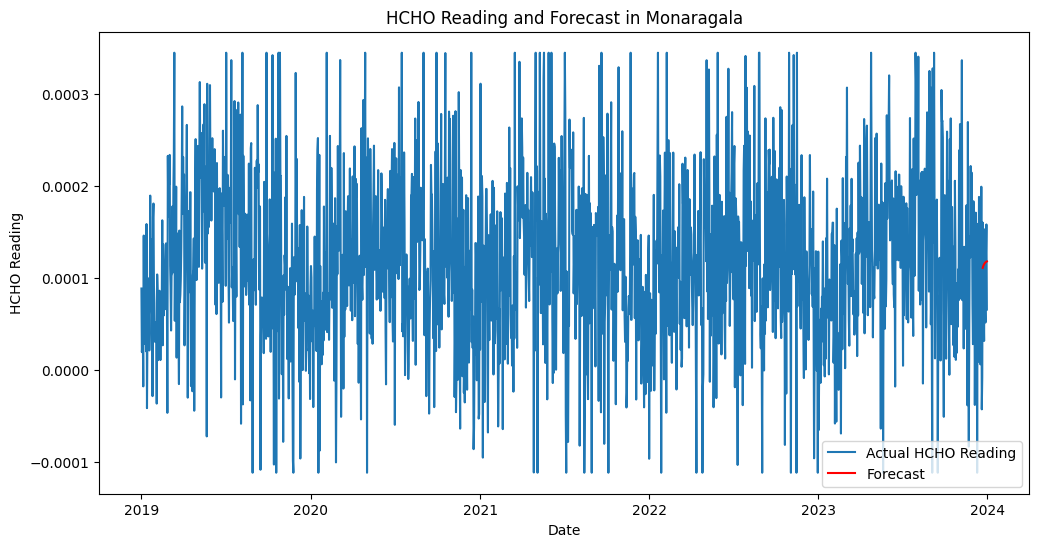

In [11]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(monaragala_data, label='Actual HCHO Reading')
plt.plot(monaragala_data.index[-10:], forecast, label='Forecast', color='red')
plt.title('HCHO Reading and Forecast in Monaragala')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [12]:
# Calculate mean squared error
mse = mean_squared_error(monaragala_data[-10:], forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 2.4925983057863353e-09


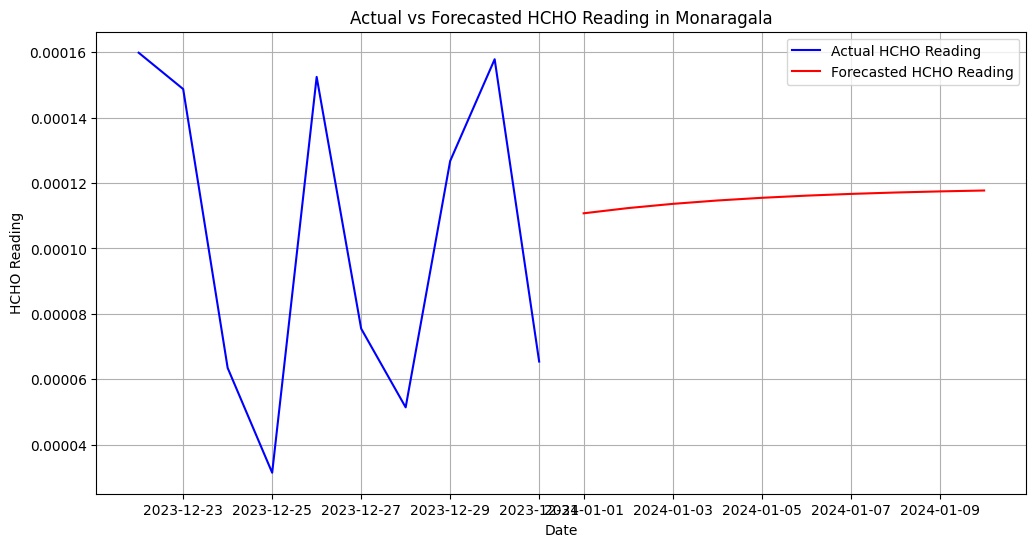

In [13]:
# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(monaragala_data[-10:], label='Actual HCHO Reading', color='blue')
plt.plot(forecast, label='Forecasted HCHO Reading', color='red')
plt.title('Actual vs Forecasted HCHO Reading in Monaragala')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.legend()
plt.show()


### Colombo

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [15]:
# Filter and prepare the series
colombo_data = combined_df[combined_df['Location'] == 'Colombo Proper']['HCHO']
colombo_data = colombo_data.asfreq('D')
colombo_data = colombo_data.fillna(method='ffill')  # Forward fill to handle NA values

# Check stationarity
adf_test = adfuller(colombo_data.dropna())
print(f'ADF Statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistics: -4.720559444473778
p-value: 7.697921531551766e-05


In [16]:
# Fit the ARIMA model
arima_model = ARIMA(colombo_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                   HCHO   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14481.375
Date:                Sun, 21 Apr 2024   AIC                         -28954.751
Time:                        11:44:56   BIC                         -28932.711
Sample:                    01-01-2019   HQIC                        -28946.621
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   7.01e-06     20.690      0.000       0.000       0.000
ar.L1          0.9180   3.13e-10   2.93e+09      0.000       0.918       0.918
ma.L1         -0.7115   2.24e-10  -3.18e+09      0.0

In [17]:
forecast = arima_result.forecast(steps=10)
forecast

2024-01-01    0.000120
2024-01-02    0.000122
2024-01-03    0.000124
2024-01-04    0.000126
2024-01-05    0.000127
2024-01-06    0.000129
2024-01-07    0.000130
2024-01-08    0.000131
2024-01-09    0.000133
2024-01-10    0.000134
Freq: D, Name: predicted_mean, dtype: float64

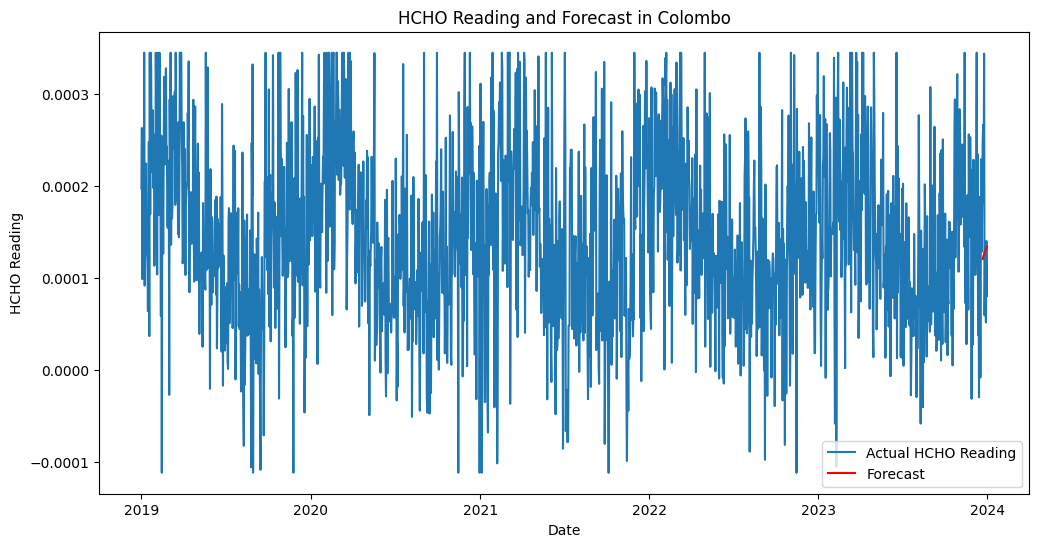

In [18]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(colombo_data, label='Actual HCHO Reading')
plt.plot(colombo_data.index[-10:], forecast, label='Forecast', color='red')
plt.title('HCHO Reading and Forecast in Colombo')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [19]:
# Calculate mean squared error
mse = mean_squared_error(colombo_data[-10:], forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 1.0493998391538864e-08


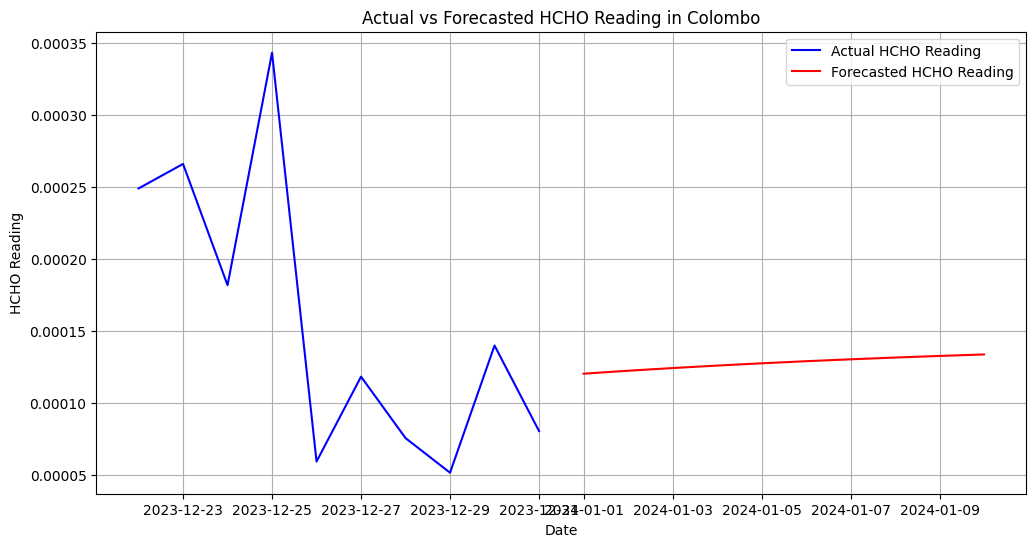

In [20]:
# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(colombo_data[-10:], label='Actual HCHO Reading', color='blue')
plt.plot(forecast, label='Forecasted HCHO Reading', color='red')
plt.title('Actual vs Forecasted HCHO Reading in Colombo')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.legend()
plt.show()


### Deniyaya, Matara

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [22]:
# Filter and prepare the series
matara_data = combined_df[combined_df['Location'] == 'Deniyaya, Matara']['HCHO']
matara_data = matara_data.asfreq('D')
matara_data = matara_data.fillna(method='ffill')  # Forward fill to handle NA values

# Check stationarity
adf_test = adfuller(matara_data.dropna())
print(f'ADF Statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistics: -12.760337080553432
p-value: 8.169368165145024e-24


In [23]:
# Fit the ARIMA model
arima_model = ARIMA(matara_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                   HCHO   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14398.432
Date:                Sun, 21 Apr 2024   AIC                         -28788.864
Time:                        11:44:57   BIC                         -28766.824
Sample:                    01-01-2019   HQIC                        -28780.734
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   3.18e-06     35.645      0.000       0.000       0.000
ar.L1          0.7011   3.94e-11   1.78e+10      0.000       0.701       0.701
ma.L1         -0.5645   2.87e-11  -1.97e+10      0.0

In [24]:
forecast = arima_result.forecast(steps=10)
forecast

2024-01-01    0.000106
2024-01-02    0.000108
2024-01-03    0.000110
2024-01-04    0.000111
2024-01-05    0.000112
2024-01-06    0.000112
2024-01-07    0.000113
2024-01-08    0.000113
2024-01-09    0.000113
2024-01-10    0.000113
Freq: D, Name: predicted_mean, dtype: float64

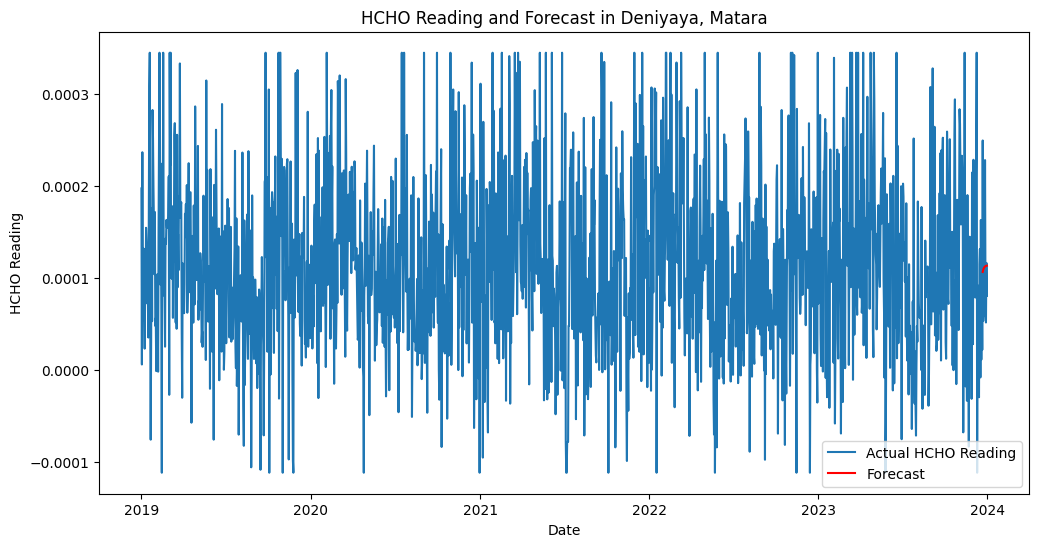

In [25]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(matara_data, label='Actual HCHO Reading')
plt.plot(matara_data.index[-10:], forecast, label='Forecast', color='red')
plt.title('HCHO Reading and Forecast in Deniyaya, Matara')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [26]:
# Calculate mean squared error
mse = mean_squared_error(matara_data[-10:], forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 4.946505742357692e-09


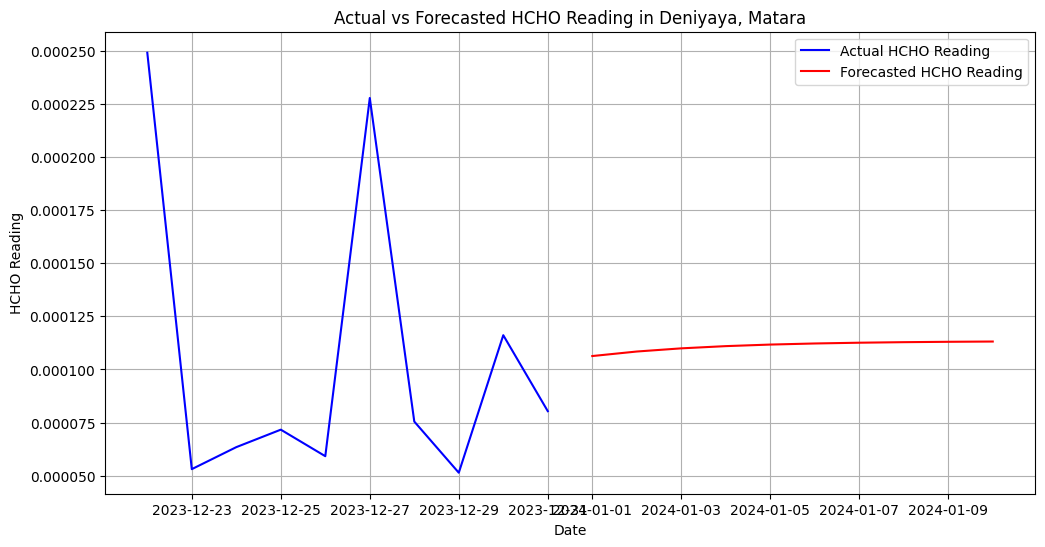

In [27]:
# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(matara_data[-10:], label='Actual HCHO Reading', color='blue')
plt.plot(forecast, label='Forecasted HCHO Reading', color='red')
plt.title('Actual vs Forecasted HCHO Reading in Deniyaya, Matara')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.legend()
plt.show()


### Jaffna

In [28]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [29]:
# Filter and prepare the series
jaffna_data = combined_df[combined_df['Location'] == 'Jaffna Proper']['HCHO']
jaffna_data = jaffna_data.asfreq('D')
jaffna_data = jaffna_data.fillna(method='ffill')  # Forward fill to handle NA values

# Check stationarity
adf_test = adfuller(jaffna_data.dropna())
print(f'ADF Statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistics: -13.159537848685286
p-value: 1.3159946642813296e-24


In [30]:
# Fit the ARIMA model
arima_model = ARIMA(jaffna_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                   HCHO   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14701.444
Date:                Sun, 21 Apr 2024   AIC                         -29394.887
Time:                        11:44:58   BIC                         -29372.848
Sample:                    01-01-2019   HQIC                        -29386.757
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   2.47e-06     44.748      0.000       0.000       0.000
ar.L1          0.4974   2.75e-11   1.81e+10      0.000       0.497       0.497
ma.L1         -0.3333   2.55e-11  -1.31e+10      0.0

In [31]:
forecast = arima_result.forecast(steps=10)
forecast

2024-01-01    0.000103
2024-01-02    0.000107
2024-01-03    0.000109
2024-01-04    0.000110
2024-01-05    0.000110
2024-01-06    0.000110
2024-01-07    0.000110
2024-01-08    0.000110
2024-01-09    0.000110
2024-01-10    0.000110
Freq: D, Name: predicted_mean, dtype: float64

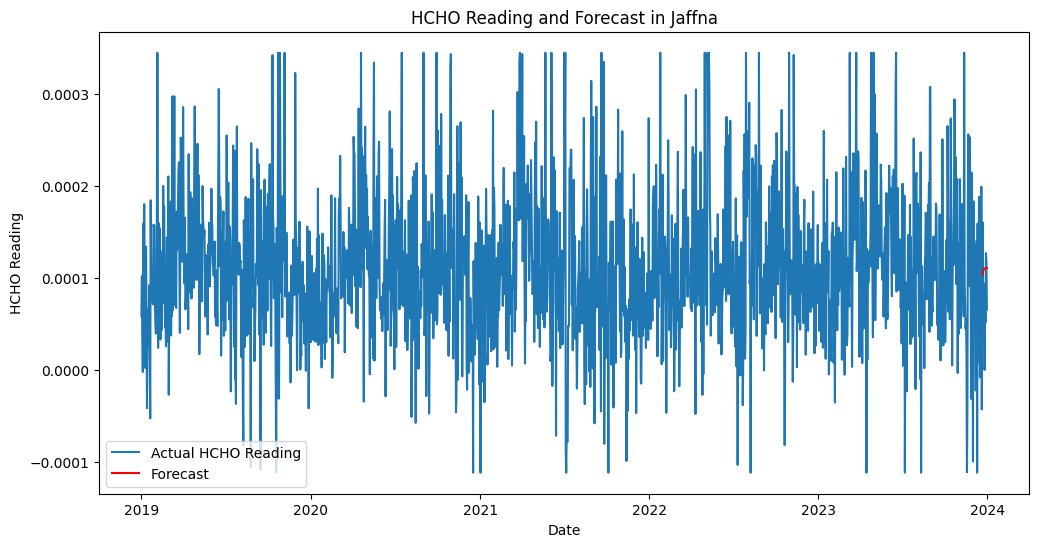

In [32]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(jaffna_data, label='Actual HCHO Reading')
plt.plot(jaffna_data.index[-10:], forecast, label='Forecast', color='red')
plt.title('HCHO Reading and Forecast in Jaffna')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [33]:
# Calculate mean squared error
mse = mean_squared_error(jaffna_data[-10:], forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 2.4982766001915874e-09


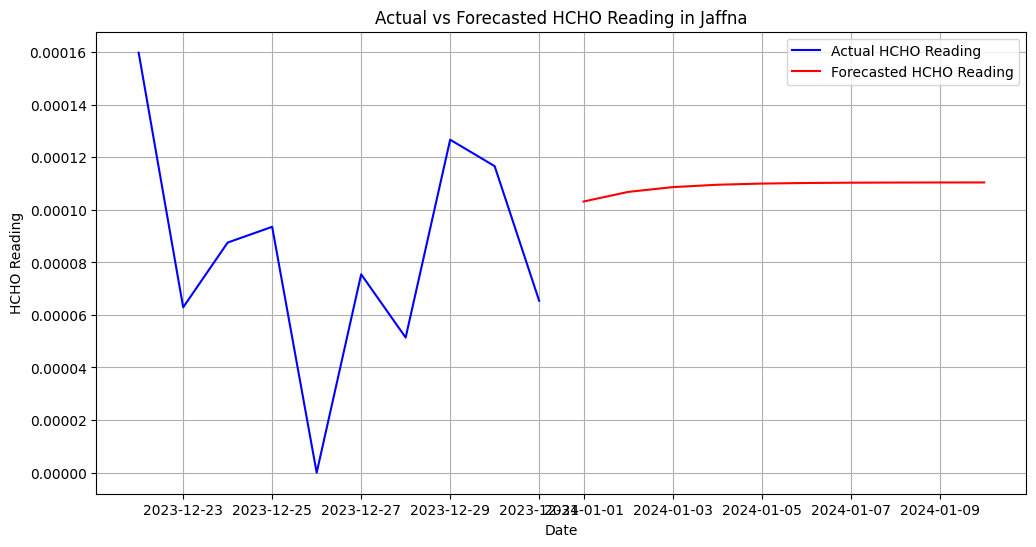

In [34]:
# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(jaffna_data[-10:], label='Actual HCHO Reading', color='blue')
plt.plot(forecast, label='Forecasted HCHO Reading', color='red')
plt.title('Actual vs Forecasted HCHO Reading in Jaffna')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.legend()
plt.show()


### Kandy

In [35]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [36]:
# Filter and prepare the series
kandy_data = combined_df[combined_df['Location'] == 'Kandy Proper']['HCHO']
kandy_data = kandy_data.asfreq('D')
kandy_data = kandy_data.fillna(method='ffill')  # Forward fill to handle NA values

# Check stationarity
adf_test = adfuller(kandy_data.dropna())
print(f'ADF Statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistics: -13.463038530706406
p-value: 3.499538786898408e-25


In [37]:
# Fit the ARIMA model
arima_model = ARIMA(kandy_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                   HCHO   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14506.005
Date:                Sun, 21 Apr 2024   AIC                         -29004.010
Time:                        11:44:59   BIC                         -28981.971
Sample:                    01-01-2019   HQIC                        -28995.881
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   2.51e-06     43.342      0.000       0.000       0.000
ar.L1          0.3244   3.32e-11   9.77e+09      0.000       0.324       0.324
ma.L1         -0.1619   3.14e-11  -5.16e+09      0.0

In [38]:
forecast = arima_result.forecast(steps=10)
forecast

2024-01-01    0.000100
2024-01-02    0.000106
2024-01-03    0.000108
2024-01-04    0.000109
2024-01-05    0.000109
2024-01-06    0.000109
2024-01-07    0.000109
2024-01-08    0.000109
2024-01-09    0.000109
2024-01-10    0.000109
Freq: D, Name: predicted_mean, dtype: float64

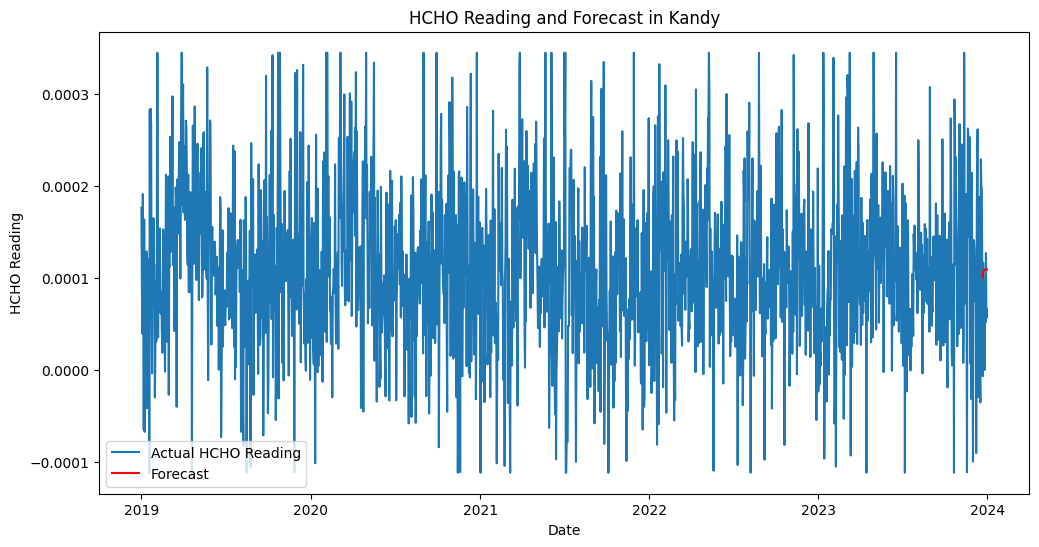

In [39]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(kandy_data, label='Actual HCHO Reading')
plt.plot(kandy_data.index[-10:], forecast, label='Forecast', color='red')
plt.title('HCHO Reading and Forecast in Kandy')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [40]:
# Calculate mean squared error
mse = mean_squared_error(kandy_data[-10:], forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 3.3600610437884493e-09


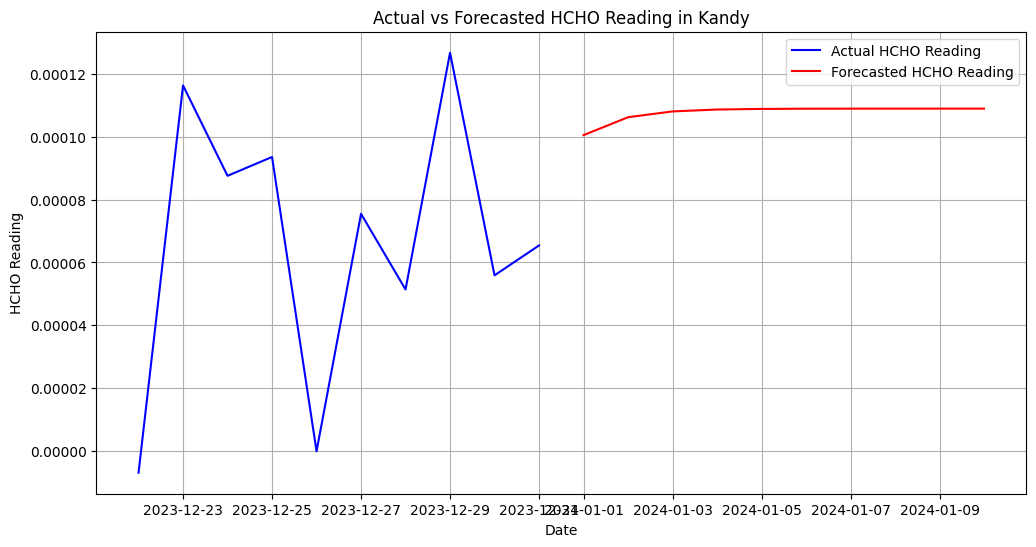

In [41]:
# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(kandy_data[-10:], label='Actual HCHO Reading', color='blue')
plt.plot(forecast, label='Forecasted HCHO Reading', color='red')
plt.title('Actual vs Forecasted HCHO Reading in Kandy')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.legend()
plt.show()


### Kurunegala

In [42]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [43]:
# Filter and prepare the series
kurunegala_data = combined_df[combined_df['Location'] == 'Kurunegala Proper']['HCHO']
kurunegala_data = kurunegala_data.asfreq('D')
kurunegala_data = kurunegala_data.fillna(method='ffill')  # Forward fill to handle NA values

# Check stationarity
adf_test = adfuller(kurunegala_data.dropna())
print(f'ADF Statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistics: -5.394432514028505
p-value: 3.4796094042676085e-06


In [44]:
# Fit the ARIMA model
arima_model = ARIMA(kurunegala_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                   HCHO   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14535.314
Date:                Sun, 21 Apr 2024   AIC                         -29062.628
Time:                        11:45:00   BIC                         -29040.588
Sample:                    01-01-2019   HQIC                        -29054.498
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    2.9e-06     43.932      0.000       0.000       0.000
ar.L1          0.6248   5.49e-11   1.14e+10      0.000       0.625       0.625
ma.L1         -0.4481   4.69e-11  -9.56e+09      0.0

In [45]:
forecast = arima_result.forecast(steps=10)
forecast

2024-01-01    0.000117
2024-01-02    0.000121
2024-01-03    0.000124
2024-01-04    0.000125
2024-01-05    0.000126
2024-01-06    0.000127
2024-01-07    0.000127
2024-01-08    0.000127
2024-01-09    0.000127
2024-01-10    0.000127
Freq: D, Name: predicted_mean, dtype: float64

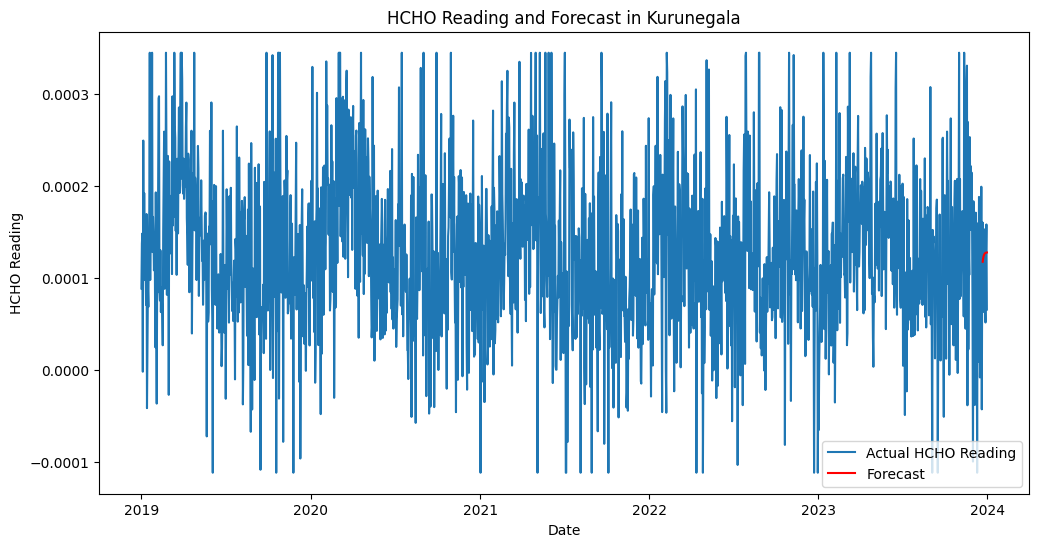

In [46]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(kurunegala_data, label='Actual HCHO Reading')
plt.plot(kurunegala_data.index[-10:], forecast, label='Forecast', color='red')
plt.title('HCHO Reading and Forecast in Kurunegala')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [47]:
# Calculate mean squared error
mse = mean_squared_error(kurunegala_data[-10:], forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 2.1283946381384225e-09


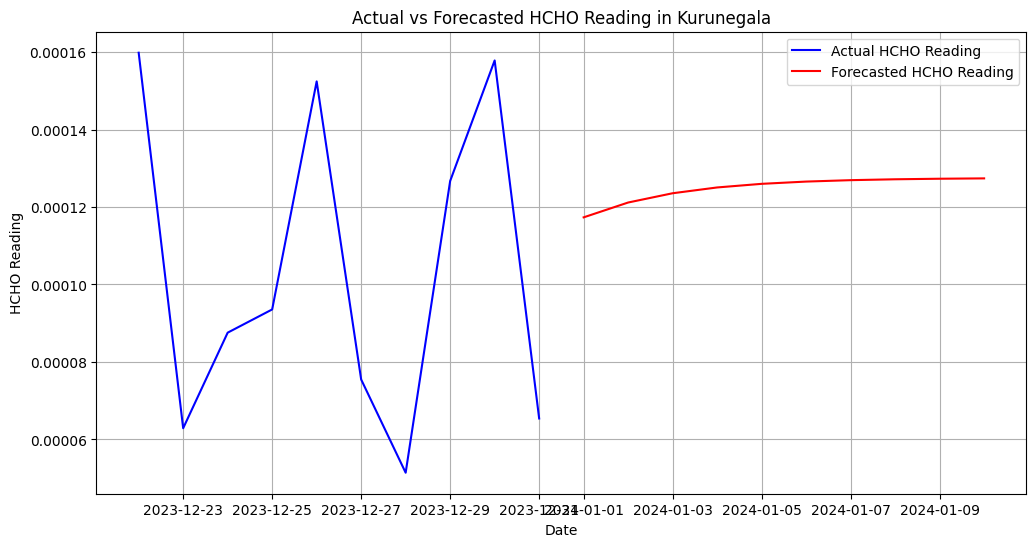

In [48]:
# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(kurunegala_data[-10:], label='Actual HCHO Reading', color='blue')
plt.plot(forecast, label='Forecasted HCHO Reading', color='red')
plt.title('Actual vs Forecasted HCHO Reading in Kurunegala')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.legend()
plt.show()


### Nuwara Eliya

In [49]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [50]:
# Filter and prepare the series
nuwara_eliya_data = combined_df[combined_df['Location'] == 'Nuwara Eliya Proper']['HCHO']
nuwara_eliya_data = nuwara_eliya_data.asfreq('D')
nuwara_eliya_data = nuwara_eliya_data.fillna(method='ffill')  # Forward fill to handle NA values

# Check stationarity
adf_test = adfuller(nuwara_eliya_data.dropna())
print(f'ADF Statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistics: -19.025050104917675
p-value: 0.0


In [51]:
# Fit the ARIMA model
arima_model = ARIMA(nuwara_eliya_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                   HCHO   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14372.765
Date:                Sun, 21 Apr 2024   AIC                         -28737.530
Time:                        11:45:01   BIC                         -28715.490
Sample:                    01-01-2019   HQIC                        -28729.400
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   2.69e-06     37.929      0.000    9.69e-05       0.000
ar.L1          0.4727    1.9e-11   2.49e+10      0.000       0.473       0.473
ma.L1         -0.3608   1.75e-11  -2.06e+10      0.0

In [52]:
forecast = arima_result.forecast(steps=10)
forecast

2024-01-01    0.000101
2024-01-02    0.000101
2024-01-03    0.000102
2024-01-04    0.000102
2024-01-05    0.000102
2024-01-06    0.000102
2024-01-07    0.000102
2024-01-08    0.000102
2024-01-09    0.000102
2024-01-10    0.000102
Freq: D, Name: predicted_mean, dtype: float64

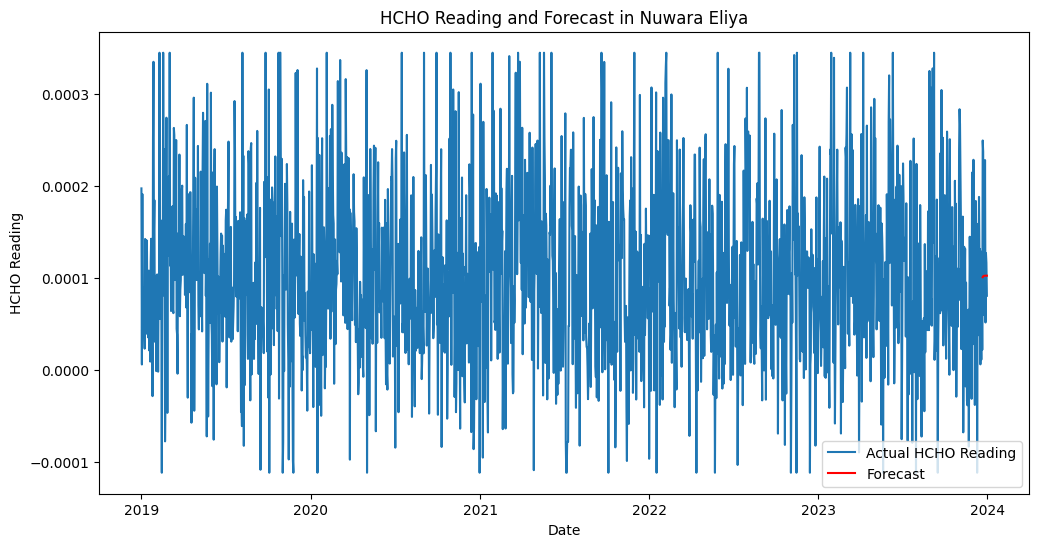

In [53]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(nuwara_eliya_data, label='Actual HCHO Reading')
plt.plot(nuwara_eliya_data.index[-10:], forecast, label='Forecast', color='red')
plt.title('HCHO Reading and Forecast in Nuwara Eliya')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [54]:
# Calculate mean squared error
mse = mean_squared_error(nuwara_eliya_data[-10:], forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 6.424054318993676e-09


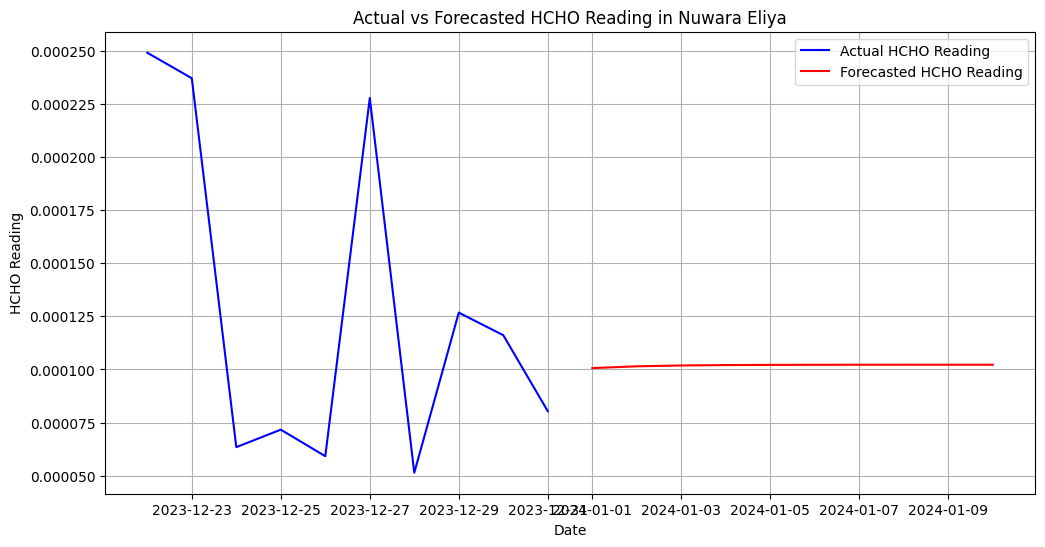

In [55]:
# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(nuwara_eliya_data[-10:], label='Actual HCHO Reading', color='blue')
plt.plot(forecast, label='Forecasted HCHO Reading', color='red')
plt.title('Actual vs Forecasted HCHO Reading in Nuwara Eliya')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.legend()
plt.show()
